# Comparing empirical vs. simulated power spectra for multiple subjects

## Setup

In [ ]:
# Generic stuff
import os,sys,glob, numpy as np, pandas as pd
from scipy.io import loadmat
from itertools import product
from scipy.interpolate import interp1d

# Viz stuff
%matplotlib inline
from matplotlib import pyplot as plt


# CTWC model code
sys.path.append('../ctwc')
from ctwc_model import run_net_sim

Define some variables

In [11]:
# 1-node weights & delays
weights_1N = np.array([[1.]])
delays_1N = np.array([[1.]])

## Load HCP data

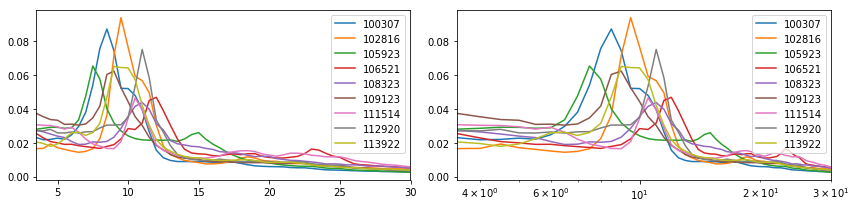

In [10]:
subs = np.loadtxt('../data/S95_MEG.txt').astype(int)
all_ps = {}
for sub in subs[:10]:
    f = '../data/%s_MEG_3-Restin_powavg.mat' %sub
    if os.path.isfile(f):
        mat = loadmat(f,struct_as_record=False,squeeze_me=True)['freq']
        hcp_ps = pd.DataFrame(mat.powspctrm,columns=mat.freq,index=mat.label).T
        hcp_ps = hcp_ps.loc[3:45]
        hcp_ps_norm = hcp_ps / hcp_ps.sum(axis=0)
        all_ps[sub] = hcp_ps_norm
df_all_ps = pd.concat(all_ps,sort=False)


fig, ax = plt.subplots(ncols=2,figsize=(12,3))
df_all_ps.mean(axis=1).unstack().T.loc[:30].plot(ax=ax[0])
df_all_ps.mean(axis=1).unstack().T.loc[:30].plot(ax=ax[1],logx=True)
plt.tight_layout()

In [38]:
# another plot with all 90 HCP subjects... ?

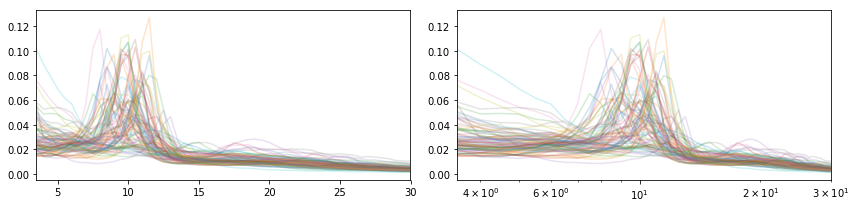

In [94]:
subs = np.loadtxt('../data/S95_MEG.txt').astype(int)
all_ps = {}
for sub in subs:
    f = '../data/%s_MEG_3-Restin_powavg.mat' %sub
    if os.path.isfile(f):
        mat = loadmat(f,struct_as_record=False,squeeze_me=True)['freq']
        hcp_ps = pd.DataFrame(mat.powspctrm,columns=mat.freq,index=mat.label).T
        hcp_ps = hcp_ps.loc[3:45]
        hcp_ps_norm = hcp_ps / hcp_ps.sum(axis=0)
        all_ps[sub] = hcp_ps_norm
df_all_ps = pd.concat(all_ps,sort=False)


fig, ax = plt.subplots(ncols=2,figsize=(12,3))
df_all_ps.mean(axis=1).unstack().T.loc[:30].plot(ax=ax[0],legend=False,alpha=0.2)
df_all_ps.mean(axis=1).unstack().T.loc[:30].plot(ax=ax[1],logx=True,legend=False,alpha=0.2)
plt.tight_layout()

## Compute modelled spectra

In [ ]:
%%time

a_thrtns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
combs = list(product(a_thrtns))
combsdicts = [{'a_th': i[0], 'a_rtn': i[0]} for i in combs]

all_sims = {}
all_corrs = {}
all_sims_norm = {}
all_corrs_norm = {}
max_corrs = {}
max_corrs_norm = {}
noise_level = 0.01
T=1024*1

meanps = df_all_ps.mean(axis=1).unstack().T
substodo = meanps.columns

all_fitcorrs = {}
all_fitdats = {}

for sub in substodo:
    
    meg_dat = meanps.loc[2:46][sub].values
    meg_freqs = meanps.loc[2:46].index.values

    for c_it,c in enumerate(combsdicts):
        ssX_params = dict(I_o=0., # None,
             wee = 1.4,wei = 1.4,wie = -3., wii = -0.5, # wie = -2.,wii = -0.5,
            wertn = 0.6,weth = .6,wthi = 0.2,wthe = 1.65,wrtnth = -2.,wthrtn = 2.,
            D_e=noise_level,D_i=noise_level,D_th=noise_level,D_rtn=noise_level,#D_e = .001,D_i= .001,D_th = 0.001,D_rtn = 0.001,
            T=T,#1024*1,#T,#T = 1024*4,# 20,
            P=1,Q = 1,Dt = 0.001,
            dt = 0.1,gain = 20.,threshold = 0.,Pi = 3.14159,
            g = 5., # 10., # 1., #-0.9,
            a_e = 0.9,
            a_i = 0.9, 
            a_th=0.25, 
            a_rtn=0.25, # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2,
            i_e = -0.35,i_i = -0.3,i_th = 0.5,i_rtn = -0.8,
            tau1  = 20.,tau2 = 5.,T_transient=1000,
            stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'],
            weights=weights_1N*0.,
            delays=delays_1N,
            K=1, #stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'], #weights=_df_w.values,delays=_df_d.values,K=83,
            return_ts=True,compute_connectivity=False,
            welch_nperseg=700)#True) #False)

        for k,v in c.items(): ssX_params[k] = v
    
        sim_res = run_net_sim(**ssX_params)
        sim_dat = sim_res[1]['e'].loc[4:45].mean(axis=1).values
        sim_freqs = sim_res[1]['e'].loc[4:45].index.values
        thing = interp1d(meg_freqs,meg_dat)
        meg_interp2sim = thing(sim_freqs)#df.index)
        all_sims[c_it] = pd.DataFrame([meg_interp2sim,sim_dat,sim_freqs],index=['meg_interp2sim', 
                                                                      'sim_dat', 'sim_freqs']).T
        all_sims[c_it].set_index('sim_freqs', inplace=True)
    
        sim_dat_norm = sim_dat/sim_dat.max()
        meg_interp2sim_norm = meg_interp2sim/meg_interp2sim.max()
    
        cc = np.corrcoef(sim_dat,meg_interp2sim)[0,1]
        all_corrs[c_it] = cc    
        df_all_corrs = pd.DataFrame(all_corrs.values(),index=all_corrs.keys())[0]
        max_corrs[c_it] = df_all_corrs.loc[df_all_corrs.idxmax()]
    
        cc_norm = np.corrcoef(sim_dat_norm,meg_interp2sim_norm)[0,1]
        all_corrs_norm[c_it] = cc_norm    
        df_all_corrs_norm = pd.DataFrame(all_corrs_norm.values(),index=all_corrs_norm.keys())[0]
        max_corrs_norm[c_it] = df_all_corrs_norm.loc[df_all_corrs_norm.idxmax()]    

    df_meg_interp2sim = pd.DataFrame(meg_interp2sim,index=sim_freqs)[0]
    df_meg_interp2sim_norm = df_meg_interp2sim = df_meg_interp2sim.max()

    df_all_sim_dats = pd.concat(all_sims)['sim_dat'].unstack().T
    df_all_sim_dats['meg_interp2sim'] = meg_interp2sim

    df_all_sim_dats_norm = df_all_sim_dats / df_all_sim_dats.max()
    df_all_sim_dats_norm['meg_interp2sim'] = meg_interp2sim_norm 

    df_max_corrs = pd.DataFrame(max_corrs.values(),index=max_corrs.keys())[0]

    maxcorridx = df_all_sim_dats_norm.corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax()

    all_fitcorrs[sub] = df_max_corrs
    all_fitdats[sub] = df_all_sim_dats_norm

df_all_fitdats = pd.concat(all_fitdats)

bestfitcorrs = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax() for s in substodo}
bestfitcorrvals = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').max() for s in substodo}

meanps_norm = meanps/meanps.max()

[(0.25,), (0.25,), (0.2,), (0.4,), (0.3,), (0.3,), (0.3,), (0.3,), (0.3,)]

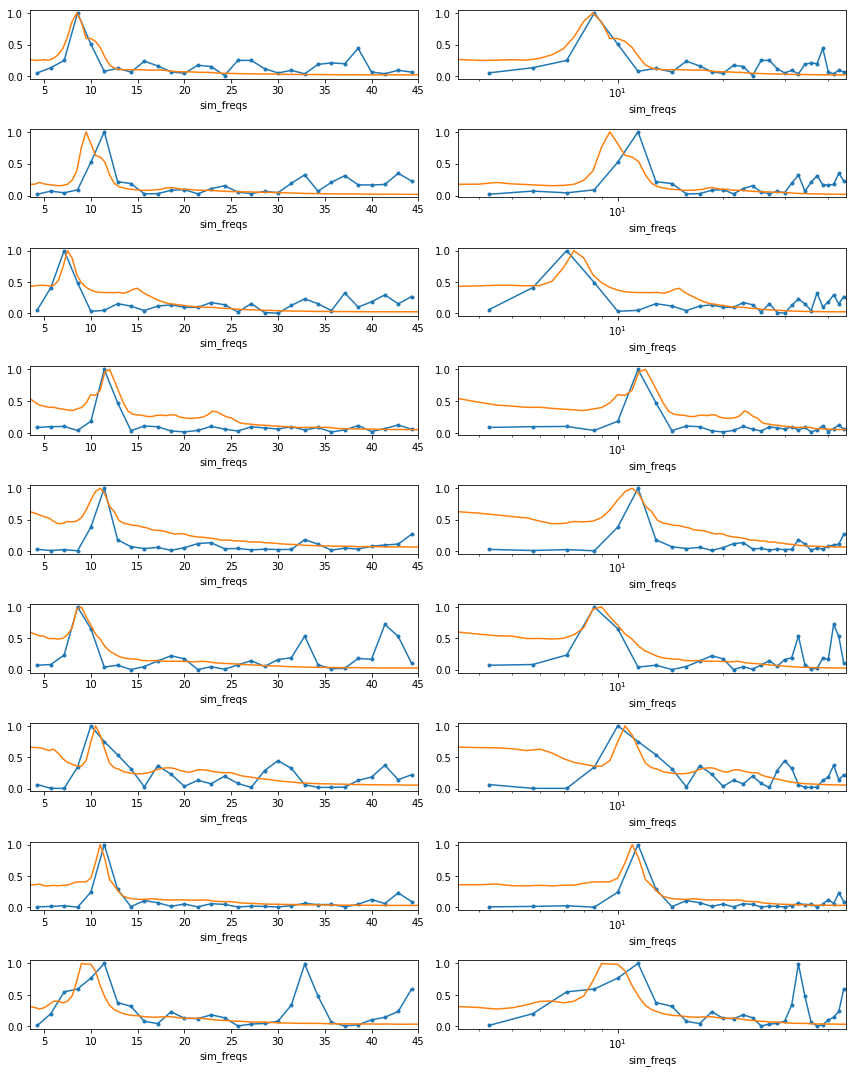

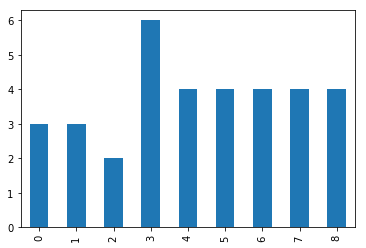

In [15]:
fig, ax = plt.subplots(nrows=len(bestfitcorrs),ncols=2,figsize=(12,15))

for kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    a = ax[kv_it,0]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.')
    meanps_norm[k].plot(ax=a)    
    
    a = ax[kv_it,1]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.',logx=True,logy=False)#True)
    meanps_norm[k].plot(ax=a,logx=True,logy=False)#True)
   
plt.tight_layout()


fig, ax  =plt.subplots()
pd.DataFrame(bestfitcorrs.values())[0].plot(kind='bar',ax=ax)

bestparam_vals = [combs[c] for c in bestfitcorrs.values()]
bestparam_vals

CPU times: user 22min 33s, sys: 6.41 s, total: 22min 39s
Wall time: 8min 16s


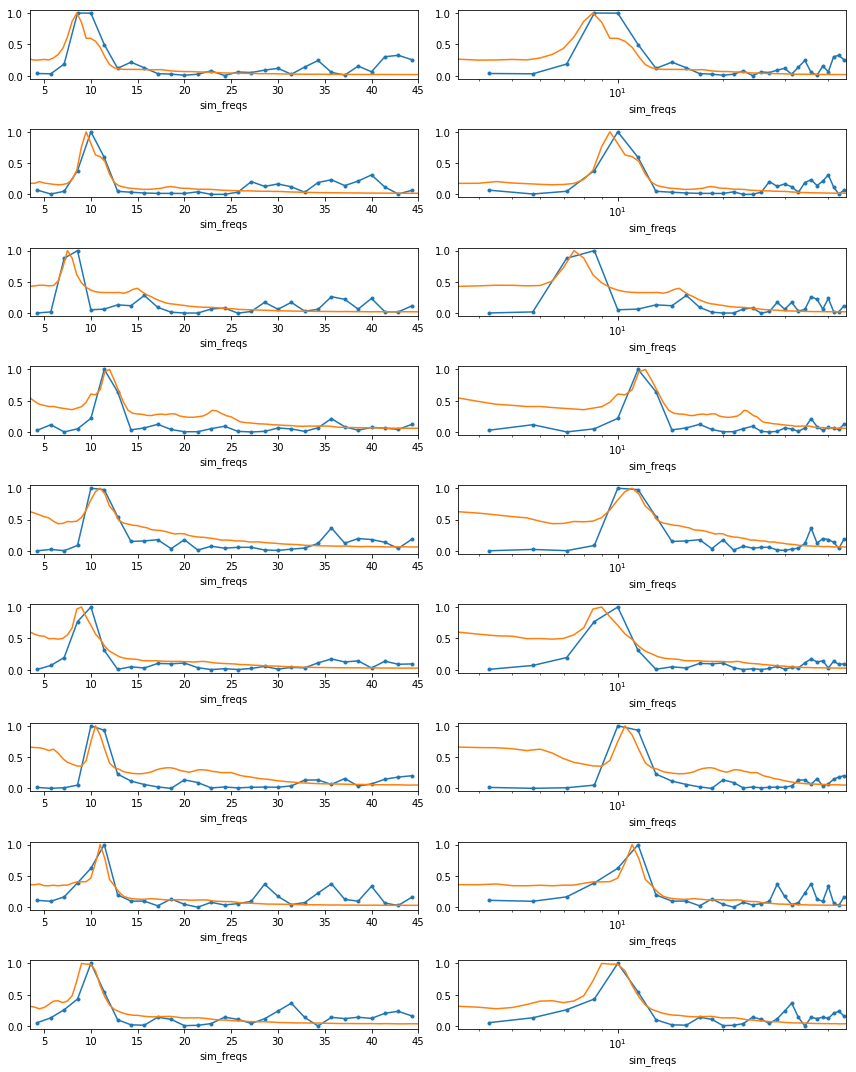

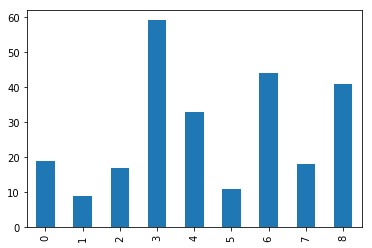

In [37]:
%%time

#aths = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6]#,0.7,0.8,0.9,1.0]
#artns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6]#,0.7,0.8,0.9,1.0]
#combs = list(product(aths,artns))
#combsdicts = [{'a_th': i[0], 'a_rtn': i[1]} for i in combs]

a_thrtns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
combs = list(product(a_thrtns,a_thrtns))
combsdicts = [{'a_th': i[0], 'a_rtn': i[1]} for i in combs]


#%%time
#_a_eis = [0.7,0.8,0.9,1.0,1.1]
a_thrtns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
all_sims = {}
all_corrs = {}
all_sims_norm = {}
all_corrs_norm = {}
max_corrs = {}
max_corrs_norm = {}
noise_level = 0.01
T=1024*1

#### meg_dat = hcp_ps_norm.loc[3:45].mean(axis=1).values
#meg_freqs = hcp_ps_norm.loc[3:45].index.values


meanps = df_all_ps.mean(axis=1).unstack().T
substodo = meanps.columns


all_fitcorrs = {}
all_fitdats = {}


for sub in substodo:
    
    meg_dat = meanps.loc[2:46][sub].values
    meg_freqs = meanps.loc[2:46].index.values
    #meg_dat = hcp_ps_norm.loc[2:46].mean(axis=1).values
    #meg_freqs = hcp_ps_norm.loc[2:46].index.values

    for c_it,c in enumerate(combsdicts):
        ssX_params = dict(I_o=0., # None,
             wee = 1.4,wei = 1.4,wie = -3., wii = -0.5, # wie = -2.,wii = -0.5,
            wertn = 0.6,weth = .6,wthi = 0.2,wthe = 1.65,wrtnth = -2.,wthrtn = 2.,
            D_e=noise_level,D_i=noise_level,D_th=noise_level,D_rtn=noise_level,#D_e = .001,D_i= .001,D_th = 0.001,D_rtn = 0.001,
            T=T,#1024*1,#T,#T = 1024*4,# 20,
            P=1,Q = 1,Dt = 0.001,
            dt = 0.1,gain = 20.,threshold = 0.,Pi = 3.14159,
            g = 5., # 10., # 1., #-0.9,
            a_e = 0.9,
            a_i = 0.9, 
            a_th=0.25, 
            a_rtn=0.25, # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2,
            i_e = -0.35,i_i = -0.3,i_th = 0.5,i_rtn = -0.8,
            tau1  = 20.,tau2 = 5.,T_transient=1000,
            stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'],
            weights=weights_1N*0.,
            delays=delays_1N,
            K=1, #stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'], #weights=_df_w.values,delays=_df_d.values,K=83,
            return_ts=True,compute_connectivity=False,
            welch_nperseg=700)#True) #False)

        for k,v in c.items(): ssX_params[k] = v
        #sim_res = run_net_sim(**ssX_params)
        #sim_dat = sim_res[2]['e'].loc[3:45].mean(axis=1).values
        #sim_freqs = sim_res[2]['e'].loc[3:45].index.values
        #thing = interp1d(meg_freqs,meg_dat)
        #meg_interp2sim = thing(sim_freqs)#df.index)
        #all_sims[_a] = pd.DataFrame([meg_dat,meg_interp2sim,sim_dat,sim_freqs],index=['meg_dat', 'interp_sim_dat', 'freqs']).T
    
        sim_res = run_net_sim(**ssX_params)
        sim_dat = sim_res[1]['e'].loc[4:45].mean(axis=1).values
        sim_freqs = sim_res[1]['e'].loc[4:45].index.values
        thing = interp1d(meg_freqs,meg_dat)
        meg_interp2sim = thing(sim_freqs)#df.index)
        all_sims[c_it] = pd.DataFrame([meg_interp2sim,sim_dat,sim_freqs],index=['meg_interp2sim', 
                                                                      'sim_dat', 'sim_freqs']).T
        all_sims[c_it].set_index('sim_freqs', inplace=True)
    
    
        #sim_dat_norm = sim_dat/sim_dat.sum()
        #meg_interp2sim_norm = meg_interp2sim/meg_interp2sim.sum()
        sim_dat_norm = sim_dat/sim_dat.max()
        meg_interp2sim_norm = meg_interp2sim/meg_interp2sim.max()
    
        cc = np.corrcoef(sim_dat,meg_interp2sim)[0,1]
        all_corrs[c_it] = cc    
        df_all_corrs = pd.DataFrame(all_corrs.values(),index=all_corrs.keys())[0]
        max_corrs[c_it] = df_all_corrs.loc[df_all_corrs.idxmax()]
    
        cc_norm = np.corrcoef(sim_dat_norm,meg_interp2sim_norm)[0,1]
        all_corrs_norm[c_it] = cc_norm    
        df_all_corrs_norm = pd.DataFrame(all_corrs_norm.values(),index=all_corrs_norm.keys())[0]
        max_corrs_norm[c_it] = df_all_corrs_norm.loc[df_all_corrs_norm.idxmax()]    
 
    
    

    df_meg_interp2sim = pd.DataFrame(meg_interp2sim,index=sim_freqs)[0]
    #df_meg_interp2sim_norm = df_meg_interp2sim = df_meg_interp2sim.sum()
    df_meg_interp2sim_norm = df_meg_interp2sim = df_meg_interp2sim.max()

    df_all_sim_dats = pd.concat(all_sims)['sim_dat'].unstack().T
    df_all_sim_dats['meg_interp2sim'] = meg_interp2sim

    #df_all_sim_dats_norm = df_all_sim_dats / df_all_sim_dats.sum()
    df_all_sim_dats_norm = df_all_sim_dats / df_all_sim_dats.max()
    df_all_sim_dats_norm['meg_interp2sim'] = meg_interp2sim_norm 

    df_max_corrs = pd.DataFrame(max_corrs.values(),index=max_corrs.keys())[0]


    maxcorridx = df_all_sim_dats_norm.corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax()


    #fig, ax = plt.subplots(ncols=2, figsize=(12,3))

    #df_all_sim_dats_norm[[maxcorridx,'meg_interp2sim']].plot(logy=True,marker='.',ax=ax[0])
    #df_all_sim_dats_norm.corr().loc['meg_interp2sim'].drop('meg_interp2sim').plot(kind='bar',ax=ax[1])
    
    all_fitcorrs[sub] = df_max_corrs
    all_fitdats[sub] = df_all_sim_dats_norm

df_all_fitdats = pd.concat(all_fitdats)

bestfitcorrs = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax() for s in substodo}
bestfitcorrvals = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').max() for s in substodo}

meanps_norm = meanps/meanps.max()

fig, ax = plt.subplots(nrows=len(bestfitcorrs),ncols=2,figsize=(12,15))

for kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    a = ax[kv_it,0]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.')
    meanps_norm[k].plot(ax=a)    
    
    a = ax[kv_it,1]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.',logx=True,logy=False)#True)
    meanps_norm[k].plot(ax=a,logx=True,logy=False)#True)
   
plt.tight_layout()


fig, ax  =plt.subplots()
pd.DataFrame(bestfitcorrs.values())[0].plot(kind='bar',ax=ax)

bestparam_vals = [combs[c] for c in bestfitcorrs.values()]
bestparam_vals

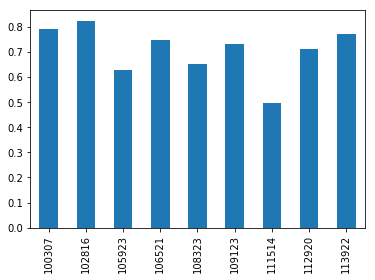

In [39]:
pd.DataFrame(bestfitcorrvals.values(),index=bestfitcorrvals.keys())[0].plot(kind='bar')

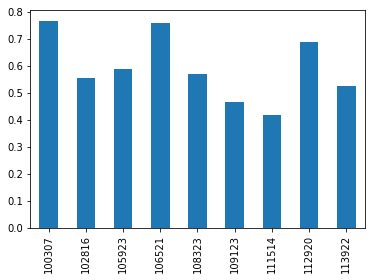

In [27]:
pd.DataFrame(bestfitcorrvals.values(),index=bestfitcorrvals.keys())[0].plot(kind='bar')

WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.


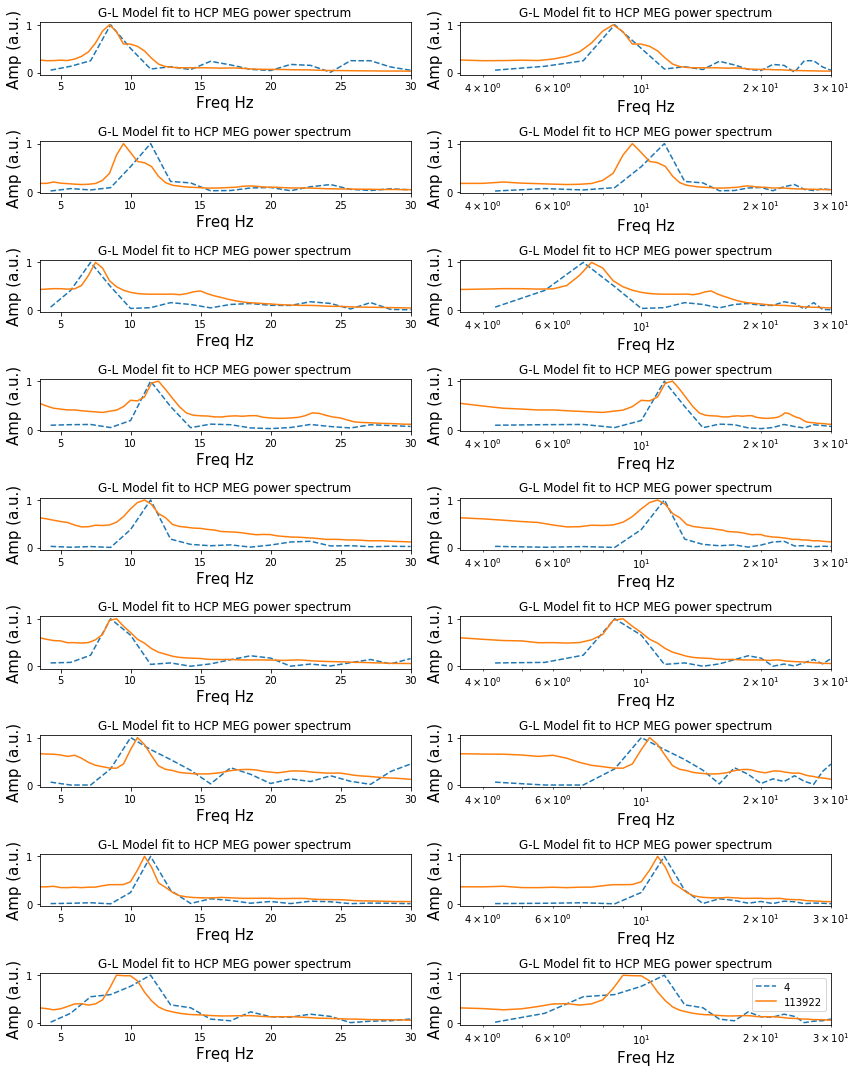

In [32]:
fig, ax = plt.subplots(nrows=len(bestfitcorrs),ncols=2,figsize=(12,15))


flow,fhigh=0.,30.
for kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    a = ax[kv_it,0]
    df_all_fitdats.loc[k][v].loc[flow:fhigh].plot(ax=a,linestyle='--')#marker='.')
    meanps_norm[k].loc[flow:fhigh].plot(ax=a)    
    
    a.set_xlabel('Freq Hz', fontsize=15)
    a.set_ylabel('Amp (a.u.)',fontsize=15)
    a.set_title('G-L Model fit to HCP MEG power spectrum')
    plt.legend()
    plt.tight_layout()
    
    
    a = ax[kv_it,1]
    df_all_fitdats.loc[k][v].loc[flow:fhigh].plot(ax=a,linestyle='--',logx=True,logy=False)# marker='.',logx=True,logy=False)#True)
    meanps_norm[k].loc[flow:fhigh].plot(ax=a,logx=True,logy=False)#True)
    
    a.set_xlabel('Freq Hz', fontsize=15)
    a.set_ylabel('Amp (a.u.)',fontsize=15)
    a.set_title('G-L Model fit to HCP MEG power spectrum')
    plt.legend()
    plt.tight_layout()


Figure Xa: Model fits for four example subject from HCP

WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.
WARNING  No handles with labels found to put in legend.


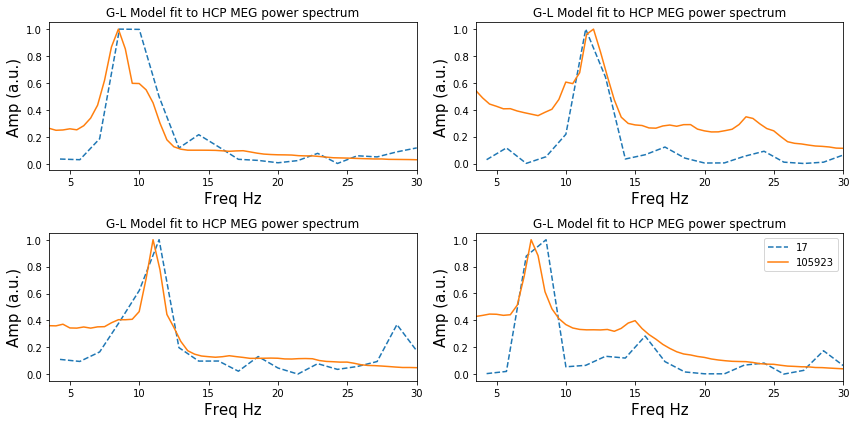

In [90]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,6))

mysubs = [100307,106521,112920,105923]

flow,fhigh=0.,30.
for s_it,s in enumerate(mysubs):
    
    idx = bestfitcorrs[s]
    
    #kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    #a = ax[kv_it,0]
    a = ax.ravel()[s_it]
    
    df_all_fitdats.loc[s][idx].loc[flow:fhigh].plot(ax=a,linestyle='--')#marker='.')
    meanps_norm[s].loc[flow:fhigh].plot(ax=a)    
    
    a.set_xlabel('Freq Hz', fontsize=15)
    a.set_ylabel('Amp (a.u.)',fontsize=15)
    a.set_title('G-L Model fit to HCP MEG power spectrum')
    plt.legend()
    plt.tight_layout()
    

Figure Xb: Distribution of model fits (corr, chisq) for 90 HCP datasets

In [91]:
bestfitcorrvals

{100307: 0.7918896428705542,
 102816: 0.8242416960238735,
 105923: 0.6264858316376539,
 106521: 0.7468896307455274,
 108323: 0.652901759849528,
 109123: 0.7305414036836809,
 111514: 0.4966003916783387,
 112920: 0.7126839301206405,
 113922: 0.7715570721669135}

## Graveyard

In [95]:
%%time

#aths = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6]#,0.7,0.8,0.9,1.0]
#artns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6]#,0.7,0.8,0.9,1.0]
#combs = list(product(aths,artns))
#combsdicts = [{'a_th': i[0], 'a_rtn': i[1]} for i in combs]

a_thrtns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
combs = list(product(a_thrtns,a_thrtns))
combsdicts = [{'a_th': i[0], 'a_rtn': i[1]} for i in combs]


#%%time
#_a_eis = [0.7,0.8,0.9,1.0,1.1]
a_thrtns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
all_sims = {}
all_corrs = {}
all_sims_norm = {}
all_corrs_norm = {}
max_corrs = {}
max_corrs_norm = {}
noise_level = 0.01
T=1024*1

#### meg_dat = hcp_ps_norm.loc[3:45].mean(axis=1).values
#meg_freqs = hcp_ps_norm.loc[3:45].index.values


meanps = df_all_ps.mean(axis=1).unstack().T
substodo = meanps.columns


all_fitcorrs = {}
all_fitdats = {}


for sub in substodo:
    
    meg_dat = meanps.loc[2:46][sub].values
    meg_freqs = meanps.loc[2:46].index.values
    #meg_dat = hcp_ps_norm.loc[2:46].mean(axis=1).values
    #meg_freqs = hcp_ps_norm.loc[2:46].index.values

    for c_it,c in enumerate(combsdicts):
        ssX_params = dict(I_o=0., # None,
             wee = 1.4,wei = 1.4,wie = -3., wii = -0.5, # wie = -2.,wii = -0.5,
            wertn = 0.6,weth = .6,wthi = 0.2,wthe = 1.65,wrtnth = -2.,wthrtn = 2.,
            D_e=noise_level,D_i=noise_level,D_th=noise_level,D_rtn=noise_level,#D_e = .001,D_i= .001,D_th = 0.001,D_rtn = 0.001,
            T=T,#1024*1,#T,#T = 1024*4,# 20,
            P=1,Q = 1,Dt = 0.001,
            dt = 0.1,gain = 20.,threshold = 0.,Pi = 3.14159,
            g = 5., # 10., # 1., #-0.9,
            a_e = 0.9,
            a_i = 0.9, 
            a_th=0.25, 
            a_rtn=0.25, # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2,
            i_e = -0.35,i_i = -0.3,i_th = 0.5,i_rtn = -0.8,
            tau1  = 20.,tau2 = 5.,T_transient=1000,
            stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'],
            weights=weights_1N*0.,
            delays=delays_1N,
            K=1, #stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'], #weights=_df_w.values,delays=_df_d.values,K=83,
            return_ts=True,compute_connectivity=False,
            welch_nperseg=700)#True) #False)

        for k,v in c.items(): ssX_params[k] = v
        #sim_res = run_net_sim(**ssX_params)
        #sim_dat = sim_res[2]['e'].loc[3:45].mean(axis=1).values
        #sim_freqs = sim_res[2]['e'].loc[3:45].index.values
        #thing = interp1d(meg_freqs,meg_dat)
        #meg_interp2sim = thing(sim_freqs)#df.index)
        #all_sims[_a] = pd.DataFrame([meg_dat,meg_interp2sim,sim_dat,sim_freqs],index=['meg_dat', 'interp_sim_dat', 'freqs']).T
    
        sim_res = run_net_sim(**ssX_params)
        sim_dat = sim_res[1]['e'].loc[4:45].mean(axis=1).values
        sim_freqs = sim_res[1]['e'].loc[4:45].index.values
        thing = interp1d(meg_freqs,meg_dat)
        meg_interp2sim = thing(sim_freqs)#df.index)
        all_sims[c_it] = pd.DataFrame([meg_interp2sim,sim_dat,sim_freqs],index=['meg_interp2sim', 
                                                                      'sim_dat', 'sim_freqs']).T
        all_sims[c_it].set_index('sim_freqs', inplace=True)
    
    
        #sim_dat_norm = sim_dat/sim_dat.sum()
        #meg_interp2sim_norm = meg_interp2sim/meg_interp2sim.sum()
        sim_dat_norm = sim_dat/sim_dat.max()
        meg_interp2sim_norm = meg_interp2sim/meg_interp2sim.max()
    
        cc = np.corrcoef(sim_dat,meg_interp2sim)[0,1]
        all_corrs[c_it] = cc    
        df_all_corrs = pd.DataFrame(all_corrs.values(),index=all_corrs.keys())[0]
        max_corrs[c_it] = df_all_corrs.loc[df_all_corrs.idxmax()]
    
        cc_norm = np.corrcoef(sim_dat_norm,meg_interp2sim_norm)[0,1]
        all_corrs_norm[c_it] = cc_norm    
        df_all_corrs_norm = pd.DataFrame(all_corrs_norm.values(),index=all_corrs_norm.keys())[0]
        max_corrs_norm[c_it] = df_all_corrs_norm.loc[df_all_corrs_norm.idxmax()]    
 
    
    

    df_meg_interp2sim = pd.DataFrame(meg_interp2sim,index=sim_freqs)[0]
    #df_meg_interp2sim_norm = df_meg_interp2sim = df_meg_interp2sim.sum()
    df_meg_interp2sim_norm = df_meg_interp2sim = df_meg_interp2sim.max()

    df_all_sim_dats = pd.concat(all_sims)['sim_dat'].unstack().T
    df_all_sim_dats['meg_interp2sim'] = meg_interp2sim

    #df_all_sim_dats_norm = df_all_sim_dats / df_all_sim_dats.sum()
    df_all_sim_dats_norm = df_all_sim_dats / df_all_sim_dats.max()
    df_all_sim_dats_norm['meg_interp2sim'] = meg_interp2sim_norm 

    df_max_corrs = pd.DataFrame(max_corrs.values(),index=max_corrs.keys())[0]


    maxcorridx = df_all_sim_dats_norm.corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax()


    #fig, ax = plt.subplots(ncols=2, figsize=(12,3))

    #df_all_sim_dats_norm[[maxcorridx,'meg_interp2sim']].plot(logy=True,marker='.',ax=ax[0])
    #df_all_sim_dats_norm.corr().loc['meg_interp2sim'].drop('meg_interp2sim').plot(kind='bar',ax=ax[1])
    
    all_fitcorrs[sub] = df_max_corrs
    all_fitdats[sub] = df_all_sim_dats_norm

df_all_fitdats = pd.concat(all_fitdats)

bestfitcorrs = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax() for s in substodo}
bestfitcorrvals = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').max() for s in substodo}

meanps_norm = meanps/meanps.max()

CPU times: user 3h 34min 39s, sys: 1min 3s, total: 3h 35min 42s
Wall time: 1h 27min 15s


WARNING  /nethome/kcni/jgriffiths/Software/miniconda3/envs/jupyter_py3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '



[(0.35, 0.2),
 (0.3, 0.15),
 (0.15, 0.3),
 (0.3, 0.35),
 (0.2, 0.5),
 (0.35, 0.15),
 (0.4, 0.2),
 (0.25, 0.4),
 (0.7, 0.1),
 (0.3, 0.2),
 (0.7, 0.15),
 (0.25, 0.2),
 (0.3, 0.15),
 (0.35, 0.1),
 (0.35, 0.2),
 (0.5, 0.15),
 (0.15, 0.5),
 (0.1, 0.35),
 (0.4, 0.35),
 (0.15, 0.15),
 (0.4, 0.35),
 (0.5, 0.1),
 (0.5, 0.15),
 (0.2, 0.15),
 (0.2, 0.25),
 (0.3, 0.2),
 (0.35, 0.15),
 (0.35, 0.1),
 (0.2, 0.3),
 (0.1, 0.25),
 (0.2, 0.2),
 (0.35, 0.15),
 (0.2, 0.5),
 (0.5, 0.25),
 (0.25, 0.35),
 (0.25, 0.1),
 (0.3, 0.35),
 (0.35, 0.1),
 (0.1, 0.1),
 (0.6, 0.2),
 (0.25, 0.35),
 (0.3, 0.2),
 (0.4, 0.2),
 (0.4, 0.25),
 (0.25, 0.15),
 (0.2, 0.4),
 (0.25, 0.4),
 (0.4, 0.1),
 (0.15, 0.3),
 (0.25, 0.35),
 (0.2, 0.35),
 (0.2, 0.3),
 (0.35, 0.25),
 (0.25, 0.3),
 (0.8, 0.2),
 (0.15, 0.25),
 (0.5, 0.15),
 (0.3, 0.3),
 (0.15, 0.1),
 (0.1, 0.5),
 (0.1, 0.6),
 (0.25, 0.35),
 (0.2, 0.35),
 (0.2, 0.3),
 (0.35, 0.15),
 (0.25, 0.3),
 (0.1, 0.15),
 (0.1, 0.15),
 (0.35, 0.25),
 (0.1, 0.2),
 (0.2, 0.35),
 (0.4, 0.3),
 (

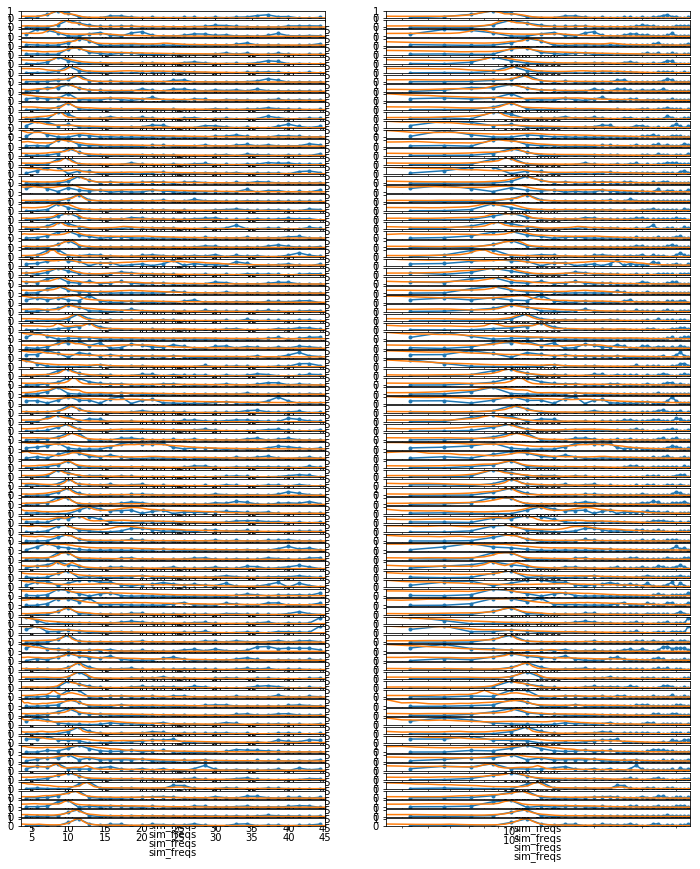

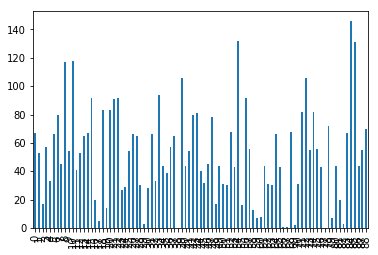

In [96]:
fig, ax = plt.subplots(nrows=len(bestfitcorrs),ncols=2,figsize=(12,15))

for kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    a = ax[kv_it,0]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.')
    meanps_norm[k].plot(ax=a)    
    
    a = ax[kv_it,1]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.',logx=True,logy=False)#True)
    meanps_norm[k].plot(ax=a,logx=True,logy=False)#True)
   
plt.tight_layout()


fig, ax  =plt.subplots()
pd.DataFrame(bestfitcorrs.values())[0].plot(kind='bar',ax=ax)

bestparam_vals = [combs[c] for c in bestfitcorrs.values()]
bestparam_vals

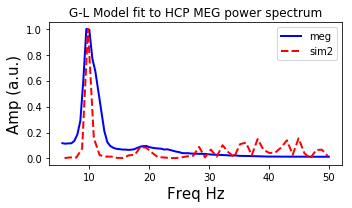

In [47]:
ssX_params = dict(I_o=0., # None,
             wee = 1.4,wei = 1.4,wie = -3., wii = -0.5, # wie = -2.,wii = -0.5,
            wertn = 0.6,weth = .6,wthi = 0.2,wthe = 1.65,wrtnth = -2.,wthrtn = 2.,
            D_e = .001,D_i= .001,D_th = 0.001,D_rtn = 0.001,
            T=T,#T = 1024*4,# 20,
            P=1,Q = 1,Dt = 0.001,
            dt = 0.1,gain = 20.,threshold = 0.,Pi = 3.14159,
            g = 5., # 10., # 1., #-0.9,
            a_e = 0.9, a_i = 0.9, 
            a_th=0.25, a_rtn=0.25, # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2,
            i_e = -0.35,i_i = -0.3,i_th = 0.5,i_rtn = -0.8,
            tau1  = 20.,tau2 = 5.,T_transient=1000,
            stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'],
            weights=weights_1N*0.,
            delays=delays_1N,
            K=1, #stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'], #weights=_df_w.values,delays=_df_d.values,K=83,
            return_ts=True,compute_connectivity=False)#True) #False)

sim_res = run_net_sim(**ssX_params)

#run_and_make_figs(ssX_params)

meg_dat = hcp_ps.loc[5:100].mean(axis=1)
#sim1_dat = simX1[2]['e'].loc[5:100].mean(axis=1)
#sim2_dat = simX2[2]['e'].loc[5:100].mean(axis=1)
sim1_dat = sim_res[2]['e'].loc[5:100].mean(axis=1)
sim2_dat = sim_res[2]['e'].loc[5:100].mean(axis=1)

meg_dat_log = np.log1p(meg_dat)
sim1_dat_log = np.log1p(sim1_dat)
sim2_dat_log = np.log1p(sim2_dat)

meg_dat_log_norm = meg_dat_log / meg_dat_log.max()
sim1_dat_log_norm = sim1_dat_log / sim1_dat_log.max()
sim2_dat_log_norm = sim2_dat_log / sim2_dat_log.max()

df = pd.concat({'meg': meg_dat_log_norm,
               'sim1': sim1_dat_log_norm,
               'sim2': sim2_dat_log_norm},axis=1)

thing = interp1d(df.meg.dropna().index,df.meg.dropna().values)
newsig = thing(df.index)
df['meg_interp'] = newsig

fig, ax = plt.subplots(figsize=(5,3))

df2 = df.copy()
df2['meg'] = df2['meg_interp']
#df2[[]'meg', 'sim'].dropna().plot(ax=ax,c='b',linewidth=2.0)#,logy=True)
df2['meg'].dropna().loc[:50].plot(ax=ax,c='b',linewidth=2.0)#,logy=True)
#df2['sim'].dropna().plot(ax=ax,c='r',linewidth=2.0,linestyle='--',logy=True)
#df2['sim2'].dropna().plot(ax=ax,c='r',linewidth=2.0,linestyle='--',logy=True)
df2['sim2'].dropna().loc[:50].plot(ax=ax,c='r',linewidth=2.0,linestyle='--')#,logy=True)

plt.legend()

ax.set_xlabel('Freq Hz', fontsize=15)
ax.set_ylabel('Amp (a.u.)',fontsize=15)
ax.set_title('G-L Model fit to HCP MEG power spectrum')

plt.tight_layout()

#plt.savefig('/home/jgriffiths/Downloads/gl_model_fit_to_HCP_MEG_power_spectrum_notrans.png', bbox_inches='tight',
#            dpi=600, transparent=False)

[(0.3,), (0.25,), (0.25,), (0.3,), (0.25,), (0.25,), (0.35,), (0.35,), (0.35,)]

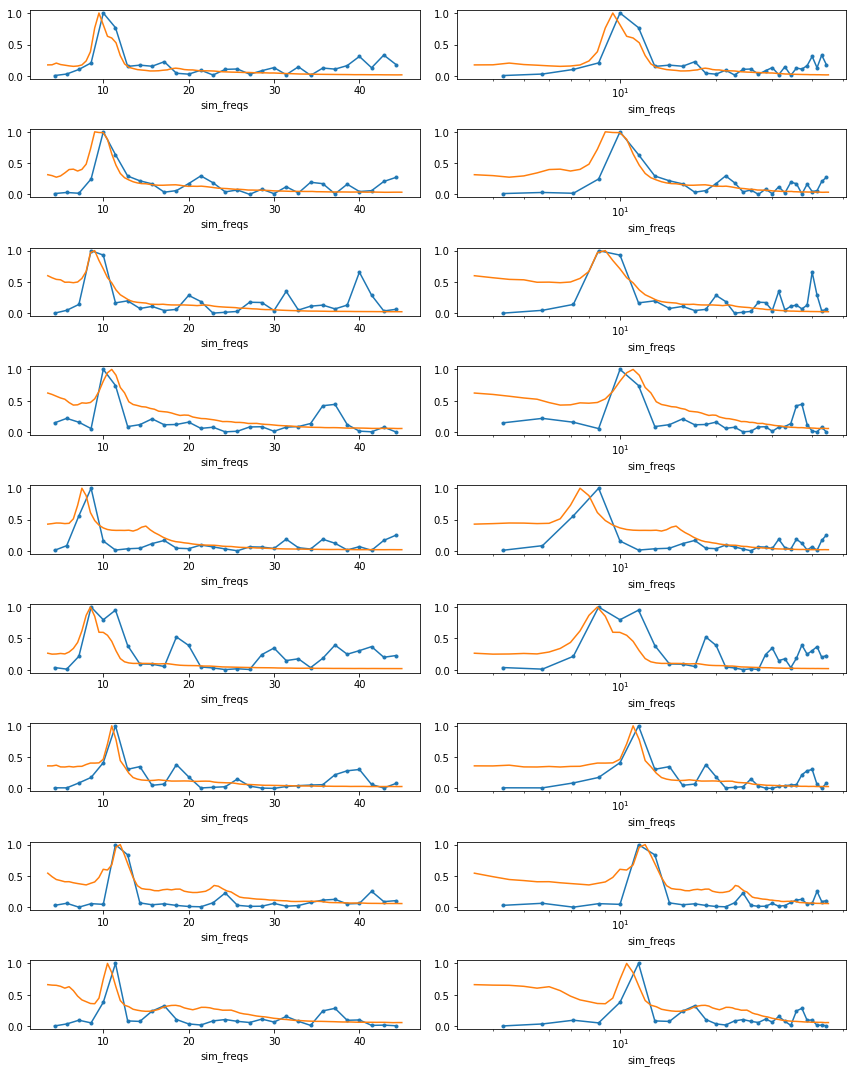

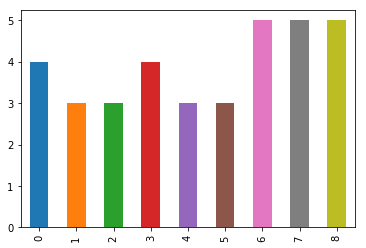

In [921]:
#aths = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6]#,0.7,0.8,0.9,1.0]
#artns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6]#,0.7,0.8,0.9,1.0]
#combs = list(product(aths,artns))
#combsdicts = [{'a_th': i[0], 'a_rtn': i[1]} for i in combs]

a_thrtns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
combs = list(product(a_thrtns))
combsdicts = [{'a_th': i[0], 'a_rtn': i[0]} for i in combs]


#%%time
#_a_eis = [0.7,0.8,0.9,1.0,1.1]
a_thrtns = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
all_sims = {}
all_corrs = {}
all_sims_norm = {}
all_corrs_norm = {}
max_corrs = {}
max_corrs_norm = {}
noise_level = 0.01
T=1024*1

#### meg_dat = hcp_ps_norm.loc[3:45].mean(axis=1).values
#meg_freqs = hcp_ps_norm.loc[3:45].index.values


meanps = df_all_ps.mean(axis=1).unstack().T
substodo = meanps.columns


all_fitcorrs = {}
all_fitdats = {}


for sub in substodo:
    
    meg_dat = meanps.loc[2:46][sub].values
    meg_freqs = meanps.loc[2:46].index.values
    #meg_dat = hcp_ps_norm.loc[2:46].mean(axis=1).values
    #meg_freqs = hcp_ps_norm.loc[2:46].index.values

    for c_it,c in enumerate(combsdicts):
        ssX_params = dict(I_o=0., # None,
             wee = 1.4,wei = 1.4,wie = -3., wii = -0.5, # wie = -2.,wii = -0.5,
            wertn = 0.6,weth = .6,wthi = 0.2,wthe = 1.65,wrtnth = -2.,wthrtn = 2.,
            D_e=noise_level,D_i=noise_level,D_th=noise_level,D_rtn=noise_level,#D_e = .001,D_i= .001,D_th = 0.001,D_rtn = 0.001,
            T=T,#1024*1,#T,#T = 1024*4,# 20,
            P=1,Q = 1,Dt = 0.001,
            dt = 0.1,gain = 20.,threshold = 0.,Pi = 3.14159,
            g = 5., # 10., # 1., #-0.9,
            a_e = 0.9,
            a_i = 0.9, 
            a_th=0.25, 
            a_rtn=0.25, # a_e = 0.3,a_i = 0.5,a_th = 0.2,a_rtn = 0.2,
            i_e = -0.35,i_i = -0.3,i_th = 0.5,i_rtn = -0.8,
            tau1  = 20.,tau2 = 5.,T_transient=1000,
            stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'],
            weights=weights_1N*0.,
            delays=delays_1N,
            K=1, #stim_freq=35.,stim_amp=0.,stim_type='sinewave',stim_pops=['e'], #weights=_df_w.values,delays=_df_d.values,K=83,
            return_ts=True,compute_connectivity=False,
            welch_nperseg=700)#True) #False)

        for k,v in c.items(): ssX_params[k] = v
        #sim_res = run_net_sim(**ssX_params)
        #sim_dat = sim_res[2]['e'].loc[3:45].mean(axis=1).values
        #sim_freqs = sim_res[2]['e'].loc[3:45].index.values
        #thing = interp1d(meg_freqs,meg_dat)
        #meg_interp2sim = thing(sim_freqs)#df.index)
        #all_sims[_a] = pd.DataFrame([meg_dat,meg_interp2sim,sim_dat,sim_freqs],index=['meg_dat', 'interp_sim_dat', 'freqs']).T
    
        sim_res = run_net_sim(**ssX_params)
        sim_dat = sim_res[1]['e'].loc[4:45].mean(axis=1).values
        sim_freqs = sim_res[1]['e'].loc[4:45].index.values
        thing = interp1d(meg_freqs,meg_dat)
        meg_interp2sim = thing(sim_freqs)#df.index)
        all_sims[c_it] = pd.DataFrame([meg_interp2sim,sim_dat,sim_freqs],index=['meg_interp2sim', 
                                                                      'sim_dat', 'sim_freqs']).T
        all_sims[c_it].set_index('sim_freqs', inplace=True)
    
    
        #sim_dat_norm = sim_dat/sim_dat.sum()
        #meg_interp2sim_norm = meg_interp2sim/meg_interp2sim.sum()
        sim_dat_norm = sim_dat/sim_dat.max()
        meg_interp2sim_norm = meg_interp2sim/meg_interp2sim.max()
    
        cc = np.corrcoef(sim_dat,meg_interp2sim)[0,1]
        all_corrs[c_it] = cc    
        df_all_corrs = pd.DataFrame(all_corrs.values(),index=all_corrs.keys())[0]
        max_corrs[c_it] = df_all_corrs.loc[df_all_corrs.idxmax()]
    
        cc_norm = np.corrcoef(sim_dat_norm,meg_interp2sim_norm)[0,1]
        all_corrs_norm[c_it] = cc_norm    
        df_all_corrs_norm = pd.DataFrame(all_corrs_norm.values(),index=all_corrs_norm.keys())[0]
        max_corrs_norm[c_it] = df_all_corrs_norm.loc[df_all_corrs_norm.idxmax()]    
 
    
    

    df_meg_interp2sim = pd.DataFrame(meg_interp2sim,index=sim_freqs)[0]
    #df_meg_interp2sim_norm = df_meg_interp2sim = df_meg_interp2sim.sum()
    df_meg_interp2sim_norm = df_meg_interp2sim = df_meg_interp2sim.max()

    df_all_sim_dats = pd.concat(all_sims)['sim_dat'].unstack().T
    df_all_sim_dats['meg_interp2sim'] = meg_interp2sim

    #df_all_sim_dats_norm = df_all_sim_dats / df_all_sim_dats.sum()
    df_all_sim_dats_norm = df_all_sim_dats / df_all_sim_dats.max()
    df_all_sim_dats_norm['meg_interp2sim'] = meg_interp2sim_norm 

    df_max_corrs = pd.DataFrame(max_corrs.values(),index=max_corrs.keys())[0]


    maxcorridx = df_all_sim_dats_norm.corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax()


    #fig, ax = plt.subplots(ncols=2, figsize=(12,3))

    #df_all_sim_dats_norm[[maxcorridx,'meg_interp2sim']].plot(logy=True,marker='.',ax=ax[0])
    #df_all_sim_dats_norm.corr().loc['meg_interp2sim'].drop('meg_interp2sim').plot(kind='bar',ax=ax[1])
    
    all_fitcorrs[sub] = df_max_corrs
    all_fitdats[sub] = df_all_sim_dats_norm

df_all_fitdats = pd.concat(all_fitdats)

bestfitcorrs = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').idxmax() for s in substodo}
bestfitcorrvals = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').max() for s in substodo}

meanps_norm = meanps/meanps.max()

fig, ax = plt.subplots(nrows=len(bestfitcorrs),ncols=2,figsize=(12,15))

for kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    a = ax[kv_it,0]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.')
    meanps_norm[k].plot(ax=a)    
    
    a = ax[kv_it,1]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.',logx=True,logy=False)#True)
    meanps_norm[k].plot(ax=a,logx=True,logy=False)#True)
   
plt.tight_layout()


fig, ax  =plt.subplots()
pd.DataFrame(bestfitcorrs.values())[0].plot(kind='bar',ax=ax)

bestparam_vals = [combs[c] for c in bestfitcorrs.values()]
bestparam_vals

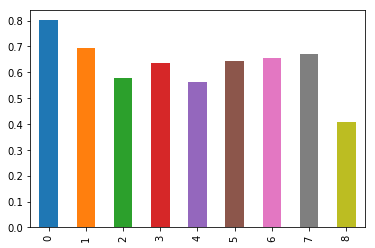

In [923]:
fig, ax = plt.subplots()
pd.DataFrame(bestfitcorrvals.values())[0].plot(kind='bar',ax=ax)

CPU times: user 57.1 s, sys: 1.08 s, total: 58.2 s
Wall time: 57 s


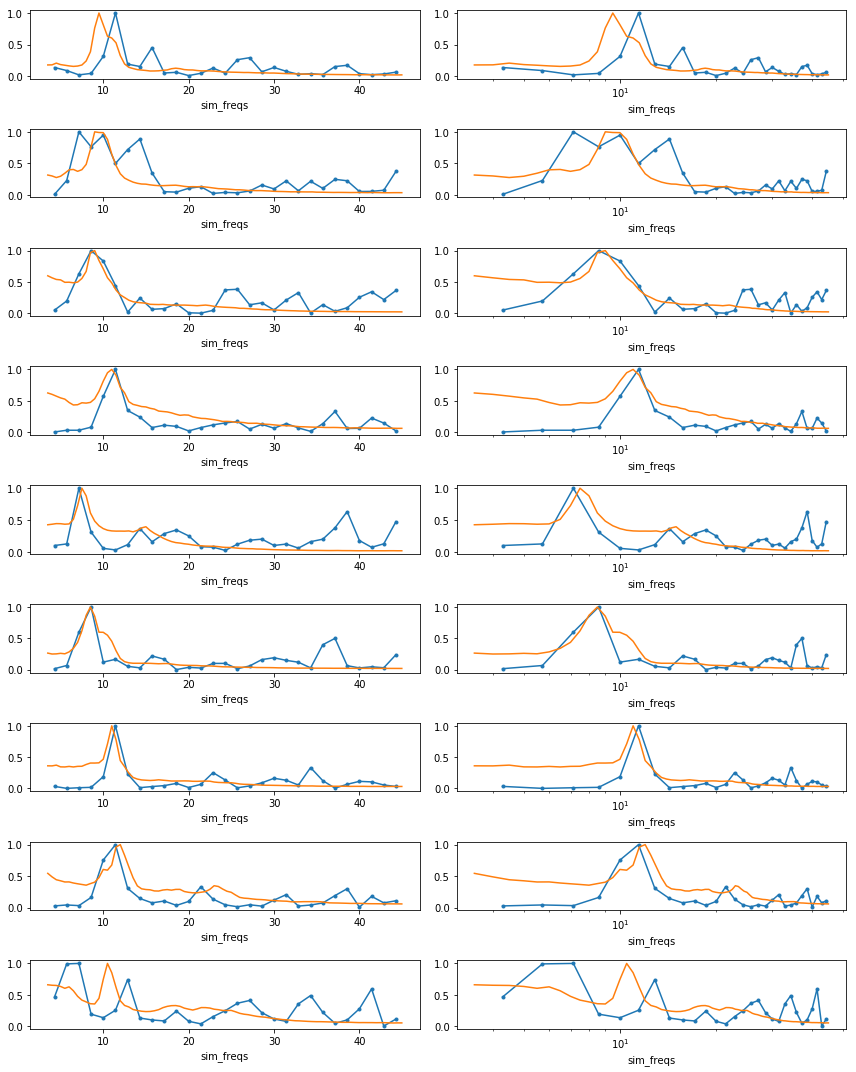

In [864]:
fig, ax = plt.subplots(nrows=len(bestfitcorrs),ncols=2,figsize=(12,15))

for kv_it,(k,v) in enumerate(bestfitcorrs.items()):
    a = ax[kv_it,0]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.')
    meanps_norm[k].plot(ax=a)    
    
    a = ax[kv_it,1]
    df_all_fitdats.loc[k][v].plot(ax=a,marker='.',logx=True,logy=False)#True)
    meanps_norm[k].plot(ax=a,logx=True,logy=False)#True)
   
plt.tight_layout()

In [ ]:
pd.DataFrame(bestfitcorrs.values())[0].plot(kind='bar')

pd.DataFrame(bestfitcorrvals.values())[0].plot(kind='bar')

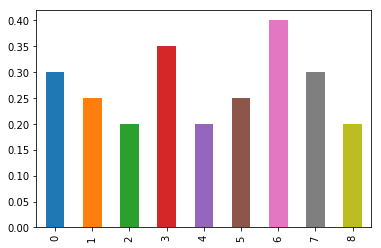

In [868]:
pd.DataFrame(bestfitcorrs.values())[0].plot(kind='bar')

In [ ]:
df_

In [893]:
bestfitcorrvals = {s: df_all_fitdats.loc[s].corr().loc['meg_interp2sim'].drop('meg_interp2sim').max() for s in substodo}


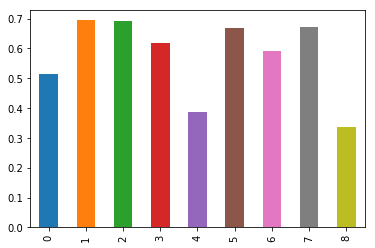

In [898]:
pd.DataFrame(bestfitcorrvals.values())[0].plot(kind='bar')

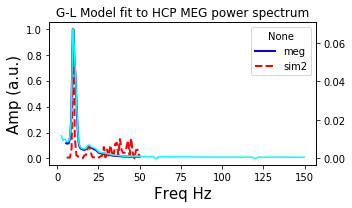

In [75]:
fig, ax = plt.subplots(figsize=(5,3))

df2 = df.copy()
df2['meg'] = df2['meg_interp']
#df2[[]'meg', 'sim'].dropna().plot(ax=ax,c='b',linewidth=2.0)#,logy=True)
df2['meg'].dropna().loc[:50].plot(ax=ax,c='b',linewidth=2.0)#,logy=True)
#df2['sim'].dropna().plot(ax=ax,c='r',linewidth=2.0,linestyle='--',logy=True)
#df2['sim2'].dropna().plot(ax=ax,c='r',linewidth=2.0,linestyle='--',logy=True)
df2['sim2'].dropna().loc[:50].plot(ax=ax,c='r',linewidth=2.0,linestyle='--')#,logy=True)

plt.legend()

ax.set_xlabel('Freq Hz', fontsize=15)
ax.set_ylabel('Amp (a.u.)',fontsize=15)
ax.set_title('G-L Model fit to HCP MEG power spectrum')



hcp_ps_norm.loc[2:].mean(axis=1).plot(ax=ax,c='cyan',secondary_y=True)


plt.tight_layout()

#plt.savefig('/home/jgriffiths/Downloads/gl_model_fit_to_HCP_MEG_power_spectrum_notrans.png', bbox_inches='tight',
#            dpi=600, transparent=False)